In [ ]:
from concurrent.futures import as_completed, ThreadPoolExecutor
from functools import partial
import hashlib
import inspect
import itertools
import os
import pickle
import random
from typing import Any, Callable, Dict, List

import equinox as eqx
import hydra
import jax
import jax.numpy as jnp
from joblib import Memory
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig, OmegaConf
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from phd.feature_search.analysis.plotting import plot_learning_curves, plot_param_sensitivity
from phd.feature_search.scripts.jax_full_feature_search import run_experiment
from phd.feature_search.jax_core.experiment_helpers import prepare_components, rng_from_string

%matplotlib inline

if not hydra.core.global_hydra.GlobalHydra().is_initialized():
    hydra.initialize(config_path='../conf')

/home/edan/local_projects/phd_research/phd/feature_search/scripts/jax_full_feature_search.py:430: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')
/tmp/ipykernel_134939/3780598853.py:30: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


In [2]:
DATA_DIR = 'data/generalization_first_experiment'
os.makedirs(DATA_DIR, exist_ok=True)

# experiment_memory = Memory(DATA_DIR)
# def cache_results(**mem_kwargs):
#     def cache_(f):
#         f.__module__ = f.__name__
#         f.__qualname__ = f.__name__
#         return experiment_memory.cache(f, **mem_kwargs)
#     return cache_

In [3]:
def get_experiment_data(hash: str):
    if not os.path.exists(os.path.join(DATA_DIR, f'{hash}.pkl')):
        return None
    
    with open(os.path.join(DATA_DIR, f'{hash}.pkl'), 'rb') as f:
        data = pickle.load(f)
    return data


def save_experiment_data(hash: str, data: Any):
    with open(os.path.join(DATA_DIR, f'{hash}.pkl'), 'wb') as f:
        pickle.dump(data, f)


def cache_fn(fn: Callable, ignore: List[str] = [], check_fn_body: bool = False):
    def cached_fn(*args, **kwargs):
        signature = inspect.signature(fn)
        bound_args = signature.bind(*args, **kwargs)
        bound_args.apply_defaults()
        args_dict = bound_args.arguments
        for ignore_arg in ignore:
            args_dict.pop(ignore_arg)
        
        for key, value in args_dict.items():
            if isinstance(value, DictConfig):
                args_dict[key] = OmegaConf.to_container(value)
        
        hash_data = args_dict
        if check_fn_body:
            hash_data = (hash_data, fn.__code__.co_code)
        
        argument_bytes = pickle.dumps(hash_data)
        hash = hashlib.sha256(argument_bytes).hexdigest()
        experiment_data = get_experiment_data(hash)
        if experiment_data is not None:
            return experiment_data
        
        result = fn(*args, **kwargs)
        save_experiment_data(hash, result)
        return result
    
    return cached_fn

In [4]:
def prepare_experiment(cfg):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker = \
        prepare_components(cfg)
    
    if cfg.seed is not None:
        rng = jax.random.key(cfg.seed)
    else:
        rng = jax.random.key(random.randint(0, 2**31))

    task_init_key = rng_from_string(rng, 'task_init_key')
    task.weights[-1] = jax.random.uniform(
        task_init_key,
        task.weights[-1].shape,
        minval = -jnp.sqrt(6 / task.weights[-1].shape[0]),
        maxval = jnp.sqrt(6 / task.weights[-1].shape[0]),
    )
    model = eqx.tree_at(
        lambda m: m.layers[-1].weight, model,
        jnp.zeros_like(model.layers[-1].weight),
    )
    return task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng


@partial(cache_fn, ignore=['show_progress'])
def prepare_and_run_experiment(cfg, show_progress: bool = True):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng = \
        prepare_experiment(cfg)
    
    jax.config.update('jax_compilation_cache_dir', cfg.jax_jit_cache_dir)
    jax.config.update('jax_persistent_cache_min_entry_size_bytes', -1)
    jax.config.update('jax_persistent_cache_min_compile_time_secs', 0.1)
    jax.config.update('jax_persistent_cache_enable_xla_caches', 'xla_gpu_per_fusion_autotune_cache_dir')
    
    results = run_experiment(
        cfg, task, model, criterion, optimizer,
        repr_optimizer, cbp_tracker, None, rng,
        show_progress = show_progress,
    )
    
    return results

In [ ]:
def set_cfg_val(cfg, param_path, val):
    path = param_path.split('.')
    sub_cfg = cfg
    for p in path[:-1]:
        sub_cfg = sub_cfg.get(p)
    sub_cfg[path[-1]] = val
    return cfg


def get_cfg_val_from_path(cfg, param_path):
    path = param_path.split('.')
    sub_cfg = cfg
    for p in path[:-1]:
        sub_cfg = sub_cfg.get(p)
    return sub_cfg[path[-1]]


def create_sweep_configs(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int):
    """Creates a cartesian product of all config changes and seeds."""
    sweep_configs = []
    base_seed = base_cfg.seed if base_cfg.seed is not None else random.randint(0, 2**30)
    
    # First create all possible combinations of parameter values
    param_names = list(sweep_params.keys())
    param_values = [sweep_params[name] for name in param_names]
    
    # For each combination of parameters
    for values in itertools.product(*param_values):
        # For each seed
        for seed in range(base_seed, base_seed + n_seeds):
            cfg = base_cfg.copy()
            cfg.seed = seed
            
            # Apply all parameter changes
            for param_path, val in zip(param_names, values):
                cfg = set_cfg_val(cfg, param_path, val)
                
            sweep_configs.append(cfg)
            
    return sweep_configs


def run_sweep(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int, n_threads: int):
    sweep_configs = create_sweep_configs(base_cfg, sweep_params, n_seeds)
    total = len(sweep_configs)
    results = []
    # Use threading instead of multiprocessing to avoid JAX fork issues
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = []
        for cfg in sweep_configs:
            futures.append(executor.submit(prepare_and_run_experiment, cfg, False))
        
        for future in tqdm(as_completed(futures), total=total, desc="Running experiments"):
            results.append(future.result())
            
    df = sweep_results_to_df(results, sweep_params)
    return df


def sweep_results_to_df(results, sweep_params):
    train_state, task, metrics = results[0]
    columns = ['run_id', 'seed'] + list(sweep_params.keys()) + list(metrics.keys())

    rows = []
    for run_id, result in enumerate(results):
        train_state, task, metrics = result
        metric_values = np.array(jnp.stack(metrics.values()).T) # (n_rows, n_metrics)
        n_rows = metric_values.shape[0]
        for i in range(n_rows):
            row = [run_id, train_state.cfg.seed]
            for param_name in sweep_params.keys():
                row.append(get_cfg_val_from_path(train_state.cfg, param_name))
            row.extend(metric_values[i].tolist())
            rows.append(row)

    return pd.DataFrame(rows, columns=columns)

In [61]:
experiment_base_cfg = DictConfig(dict(
    seed = 20250927,
    task = {
        'name': 'nonlinear_geoff',
        'n_features': 128,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 4,
        'n_stationary_layers': '${task.n_layers}',
        'hidden_dim': 128,
        'activation': 'ltu',
        'sparsity': 0.99,
        'weight_init': 'binary',
        'noise_std': 0.0,
    },
    train = {
        'batch_size': 1,
        'total_steps': 1_000_000,
        'standardize_cumulants': True,
        'log_freq': 1000,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 4,
        'hidden_dim': 256,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'rmsprop',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='nonlinear_geoff')
cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

/home/edan/miniconda3/envs/jax/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'nonlinear_geoff': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Optimizer sweep

In [ ]:
step_sizes = jnp.array([2**i for i in range(-3, -10, -1)]).tolist()

sweep_params = {
    'optimizer.learning_rate': step_sizes,
    'optimizer.name': ['rmsprop', 'adam', 'sgd']
}


### Run Sweep ###

df = run_sweep(
    cfg,
    sweep_params = sweep_params,
    n_seeds = 3,
    n_threads = 6,
)


### Param Sensitivity Plot ###

plot_param_sensitivity(
    run_df = df,
    config_df = None,
    x_col = 'optimizer.learning_rate',
    title = 'Optimizer Comparison',
    x_label = 'step-size',
    y_label = 'loss',
    metric_col = 'loss',
    metric_type = 'final_avg', # {'cumulative', 'final_avg', 'last'}
    step_col = 'samples',
    id_col = 'run_id',
    hue_col = 'optimizer.name',
    legend_title = 'Optimizer',
    show_ci = True,
    pow_2_x_axis = True,
)
plt.show()


### Learning Curve Plot ###

plot_learning_curves(
    run_df = df,
    subplot_col = 'optimizer.name',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Optimizer',
    same_y_axis = True,
    x_col = 'step',
    y_col = 'loss',
    y_label = 'loss',
    hue_col = 'optimizer.learning_rate',
    legend_title = 'Step Size',
)

Running experiments:   0%|          | 0/63 [00:01<?, ?it/s]
/home/edan/local_projects/phd_research/phd/feature_search/jax_core/experiment_helpers.py:359: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  cbp_tracker = CBPTracker(


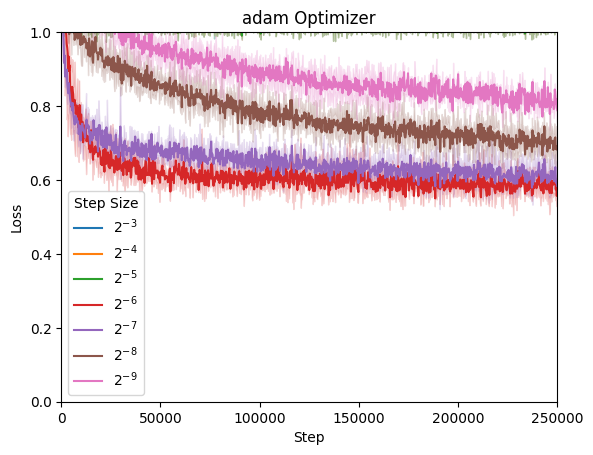

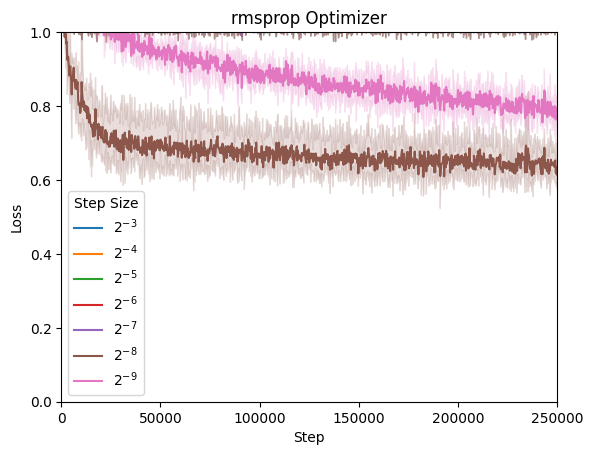

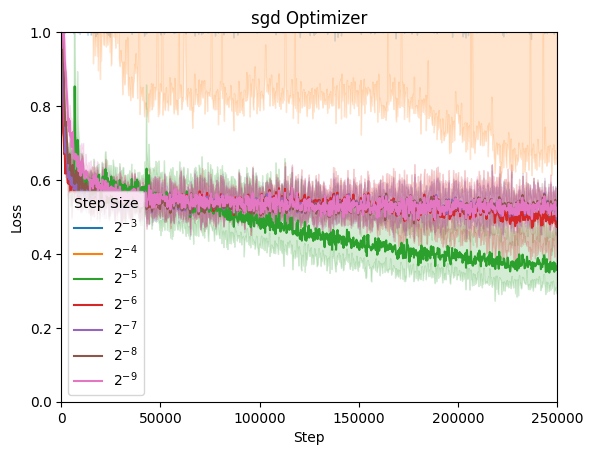

In [7]:
for optimizer_name, optim_df in df.groupby('optimizer.name'):
    # Convert learning rates to 2^n format
    optim_df['optimizer.learning_rate'] = optim_df['optimizer.learning_rate'].apply(
        lambda x: f'$2^{{{int(np.log2(float(x)))}}}$' if float(x) != 0 else '0')
    sns.lineplot(data=optim_df, x='samples', y='loss', hue='optimizer.learning_rate')
    plt.title(f'{optimizer_name} Optimizer')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.xlim(0, df['samples'].max())
    plt.ylim(0, 1)
    plt.legend(title='Step Size')
    plt.show()